In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

data = pd.read_excel("bluechip.xlsx")

In [3]:
def plot_categorical(data, show, based_on, ax):
    """
    Plot the values in the 'show' column, subdivided by the values in the 'based_on' column.

    Parameters:
        - show ("str"): A column containing data for the shows to be plotted.
        - based_on ("str"): A column containing data used to subdivide the shows.

    Returns:
        None
    """
    sns.countplot(data = data, y = show, hue = based_on, orient = 'v', order = sorted(data[show].unique()), ax = ax)
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i])
    ax.set_title(f"{' '.join(show.split('_'))} based on {' '.join(based_on.split('_'))}")

def show_attrition_percentages(data, based_on, ax):
    
    tmp_df = data.groupby(based_on)["Attrition"].apply(lambda x: sum(x == "Attrited Customer") / len(x))
    tmp_df.name = "Attrition (%)"
    df = pd.DataFrame(round(tmp_df * 100, 1))
    df = df.reset_index()
    
    tbl = ax.table(cellText = df.values, rowLabels = df.index, 
                   bbox = [0,0.5,1.5,0.5], colLabels=df.columns)
    tbl.set_fontsize(12)
    ax.axis('off')
    


def report(data, show, based_on, show_table = True):
    if show_table:
        fig, ax = plt.subplots(ncols = 2, figsize = (12,8))
        plot_categorical(data = data, show = show, based_on=based_on, ax = ax[0])
        show_attrition_percentages(data = data, based_on = based_on if based_on != "Attrition" else show, ax = ax[1])
    else:
        fig, ax = plt.subplots(figsize = (12,8))
        plot_categorical(data = data, show = show, based_on=based_on, ax = ax)
        
   
    plt.show()

In [4]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit
0,768805383,Attrited Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0


# Preprocess Data

In [5]:
def map_months_active(x):
    return f"{x // 12} years"

In [6]:
# Check for missing values

data.isnull().sum() # Returns 0 for everything, so no missing data

# Rename columns to be more descriptive

def rename_cols(dataframe, from_column, to_column):
    new_df = dataframe.rename({from_column:to_column}, axis = 1)
    return new_df

data = rename_cols(data, "Attrition_Flag", "Attrition")
data = rename_cols(data, "Customer_Age", "Age")
data = rename_cols(data, "Total_Relationship_Count", "Products_Owned")
data = rename_cols(data, "Months_on_book", "Months_joined")

# Group Columns into bins
data['Age'] = data['Age'].apply(lambda x: f"{x // 10 * 10}-{x // 10 * 10 + 9}")
data['Join_duration'] = data['Months_joined'].apply(lambda x: map_months_active(x))

# Drop unecessary columns
data = data.drop(['Months_joined', 'CLIENTNUM'], axis = 1)

data.head()

,Attrition,Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Products_Owned,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Join_duration
0,Attrited Customer,40-49,M,3,High School,Married,$60K - $80K,Blue,5,1,3,12691.0,3 years
1,Existing Customer,40-49,F,5,Graduate,Single,Less than $40K,Blue,6,1,2,8256.0,3 years
2,Existing Customer,50-59,M,3,Graduate,Married,$80K - $120K,Blue,4,1,0,3418.0,3 years
3,Existing Customer,40-49,F,4,High School,Unknown,Less than $40K,Blue,3,4,1,3313.0,2 years
4,Existing Customer,40-49,M,3,Uneducated,Married,$60K - $80K,Blue,5,1,0,4716.0,1 years


In [7]:
attrited_data = data.query("Attrition == 'Attrited Customer'")

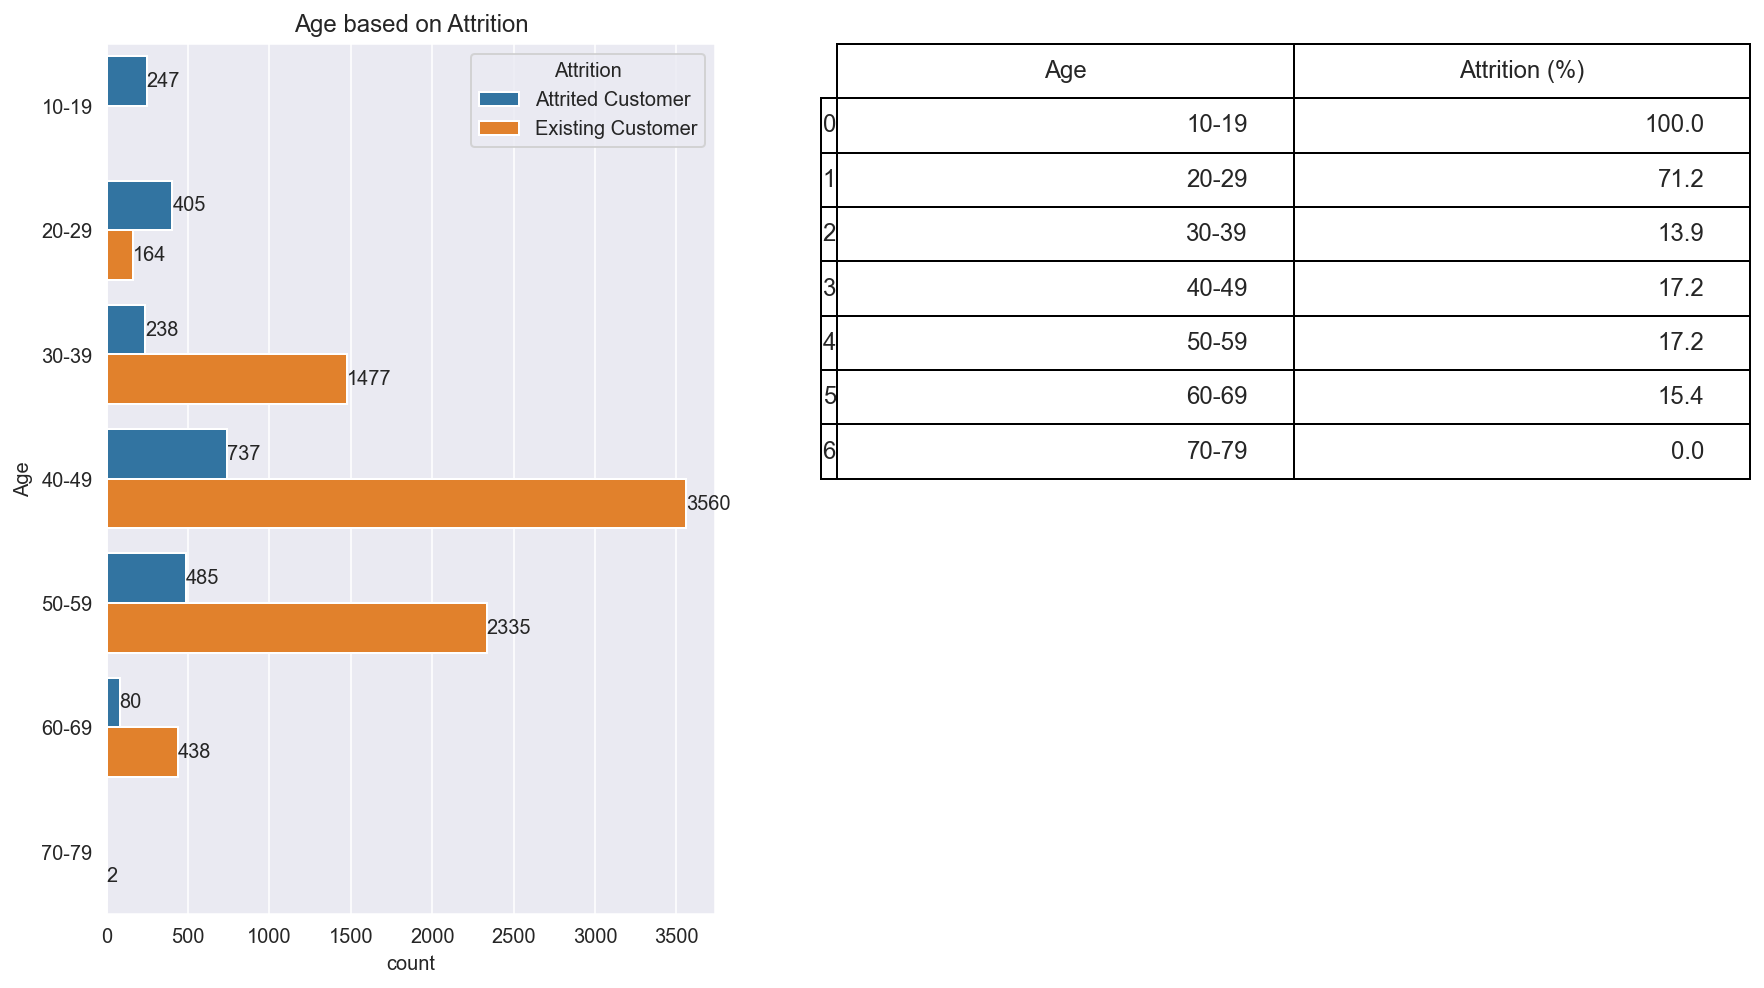

In [8]:
report(data, show = "Age", based_on = "Attrition")

**Observations**:
- There is a very high attrition percentage for people in their teens and 20s (100% and 71.2% respectively)
    - 100% of people from 10-19s are college students
- Other age groups seem to hover around the same percentages (15%), which is industry average

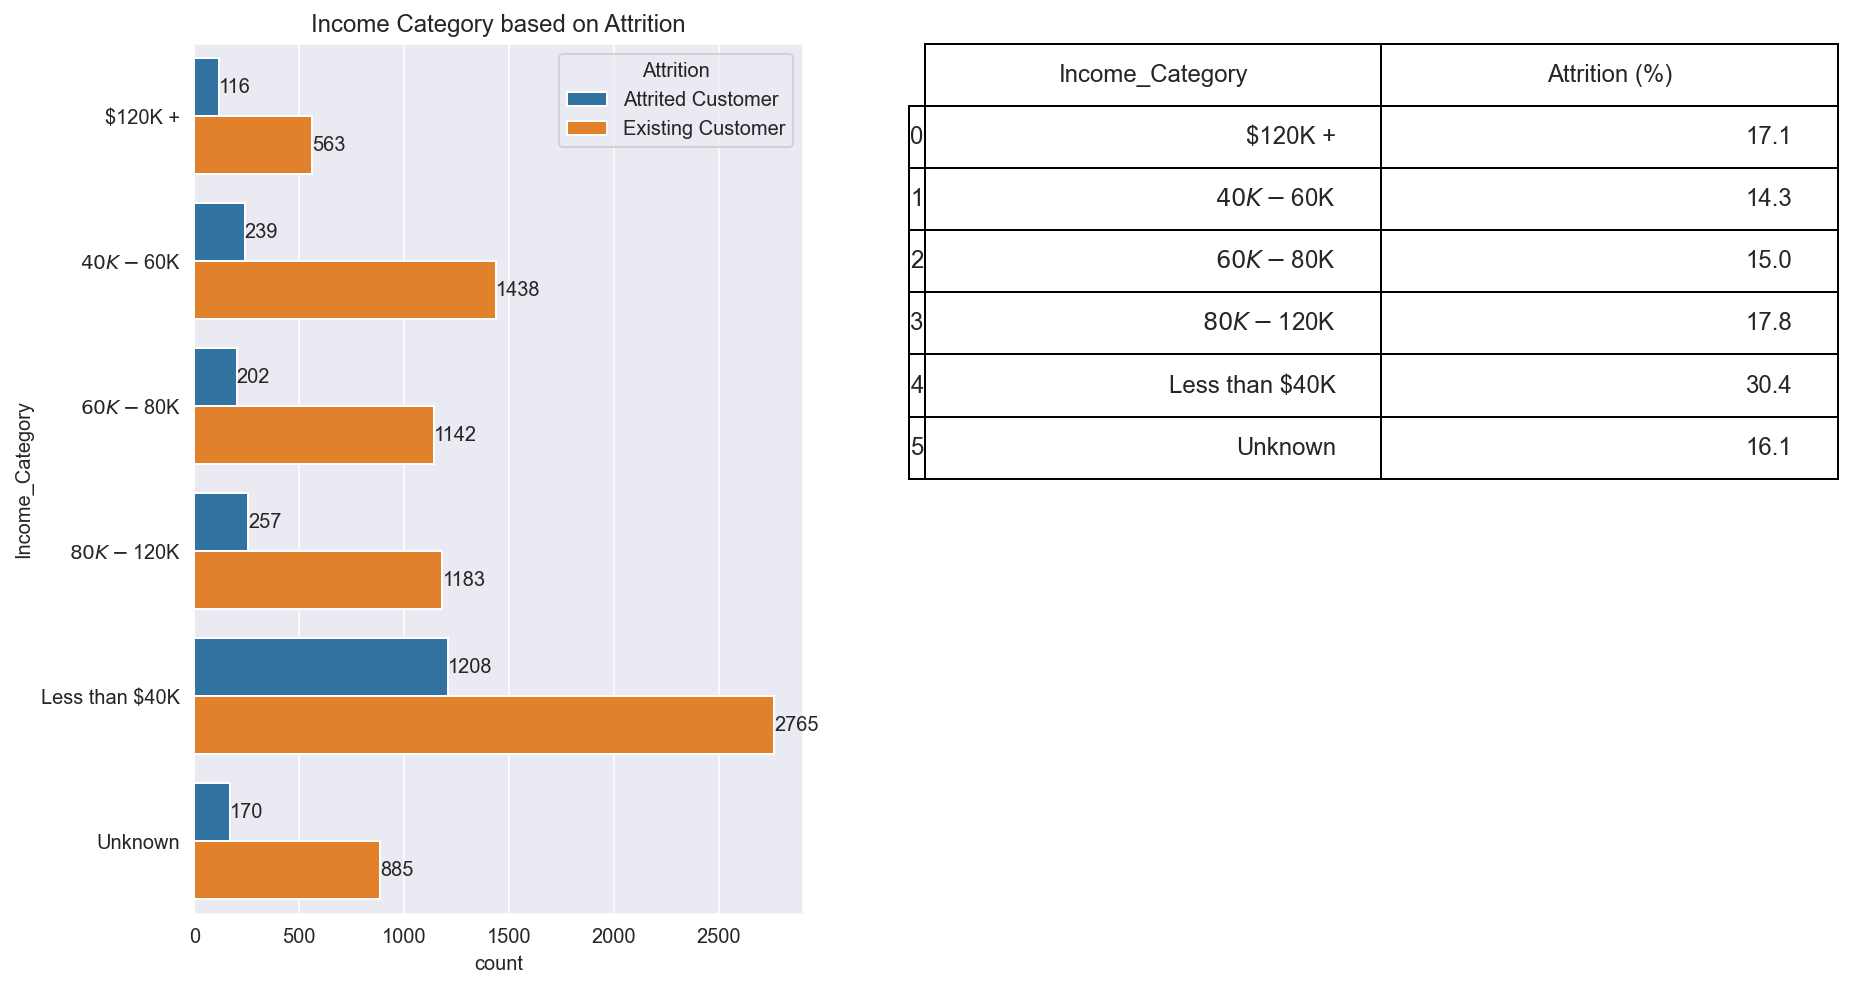

In [9]:
report(data, show = "Income_Category", based_on = "Attrition")

**Observations**:
- Low income rates (<40%) have significantly higher attrition rates compared to other income brackets -> possibly due to inability to incur credit card costs after initial cashback period

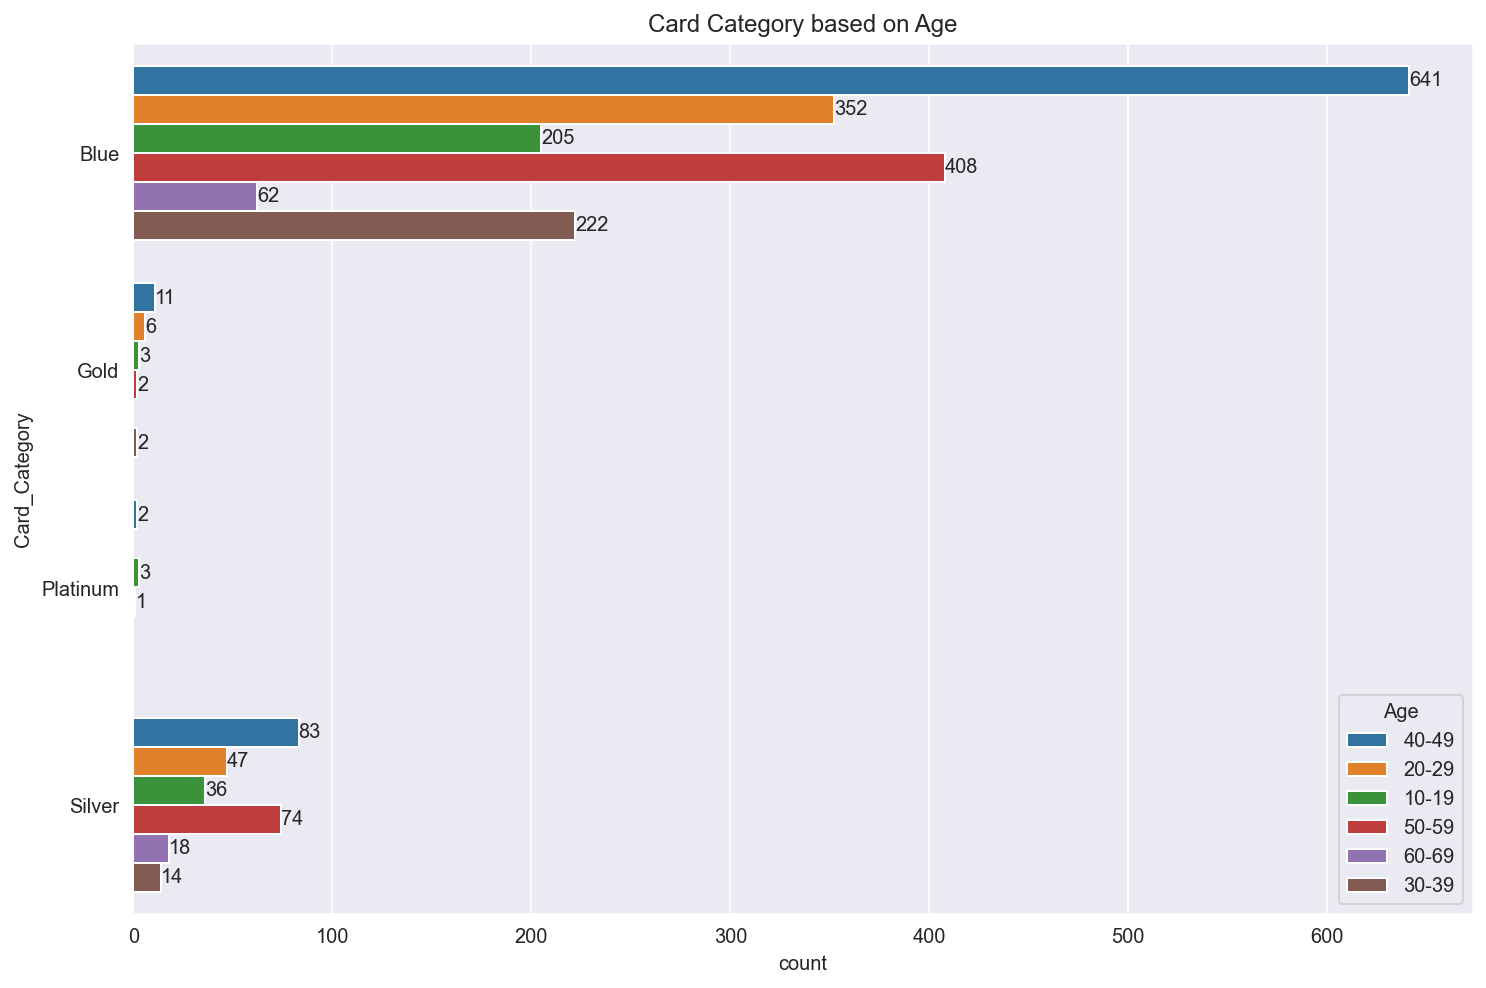

In [10]:
report(attrited_data, show = "Card_Category", based_on = "Age", show_table = False)

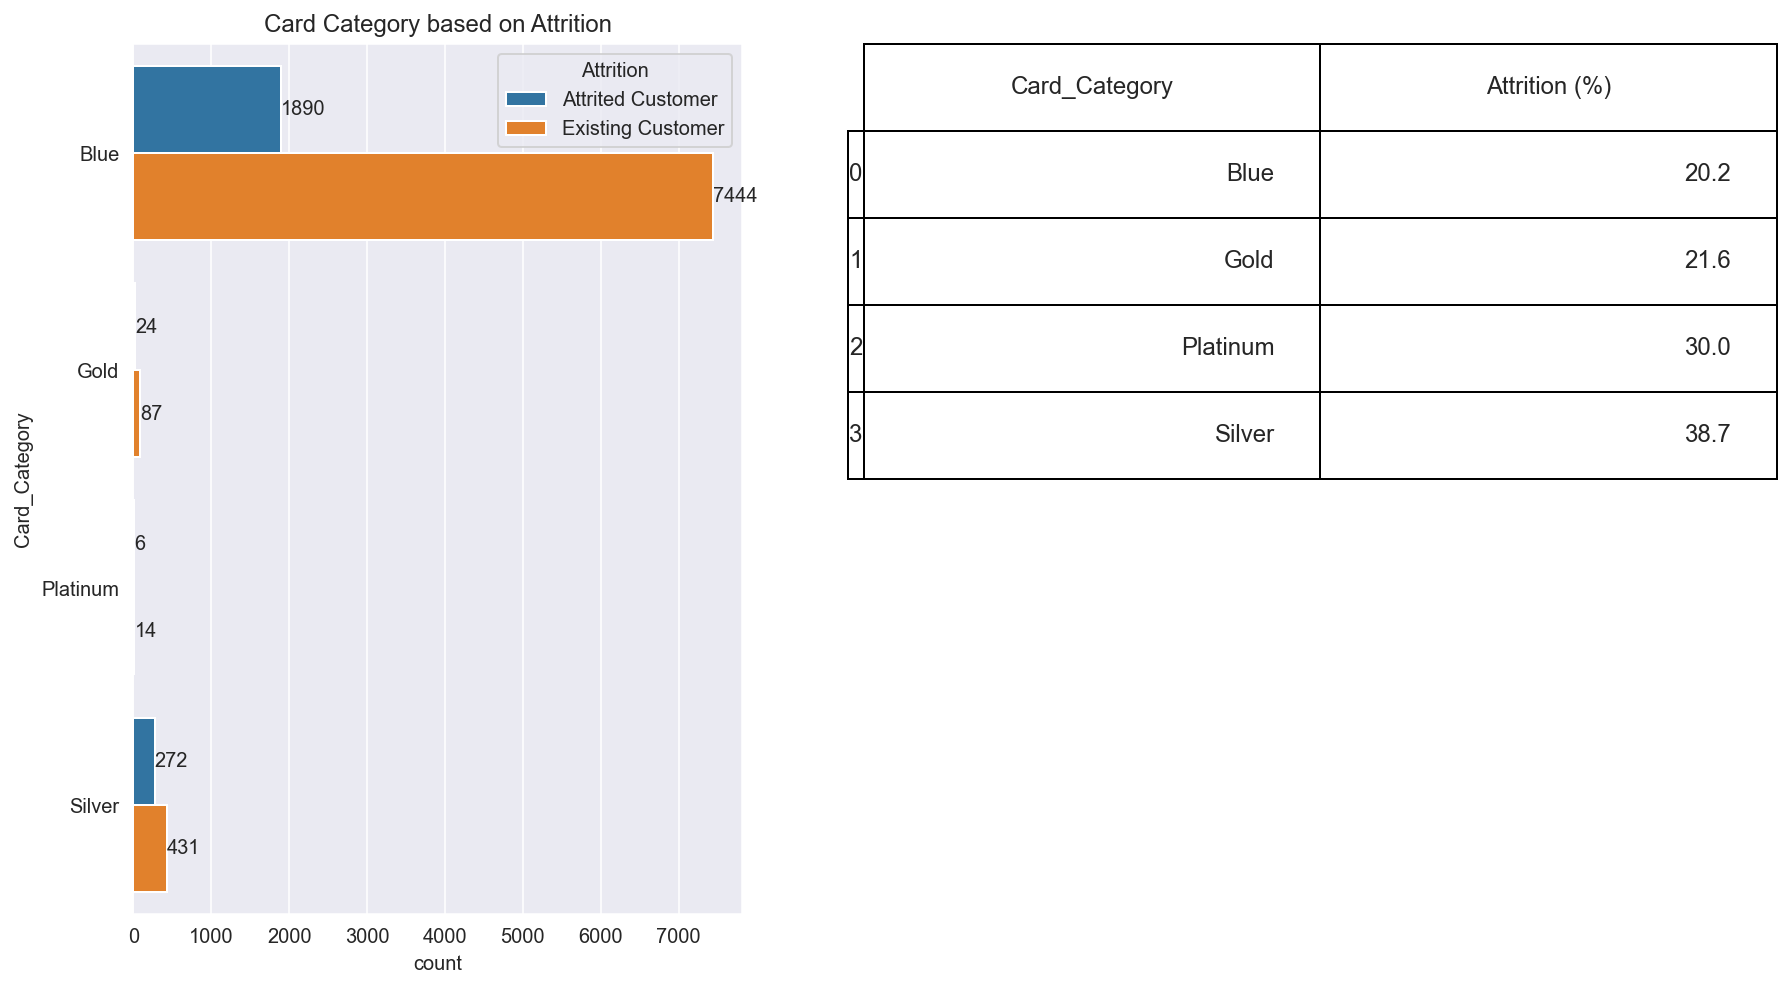

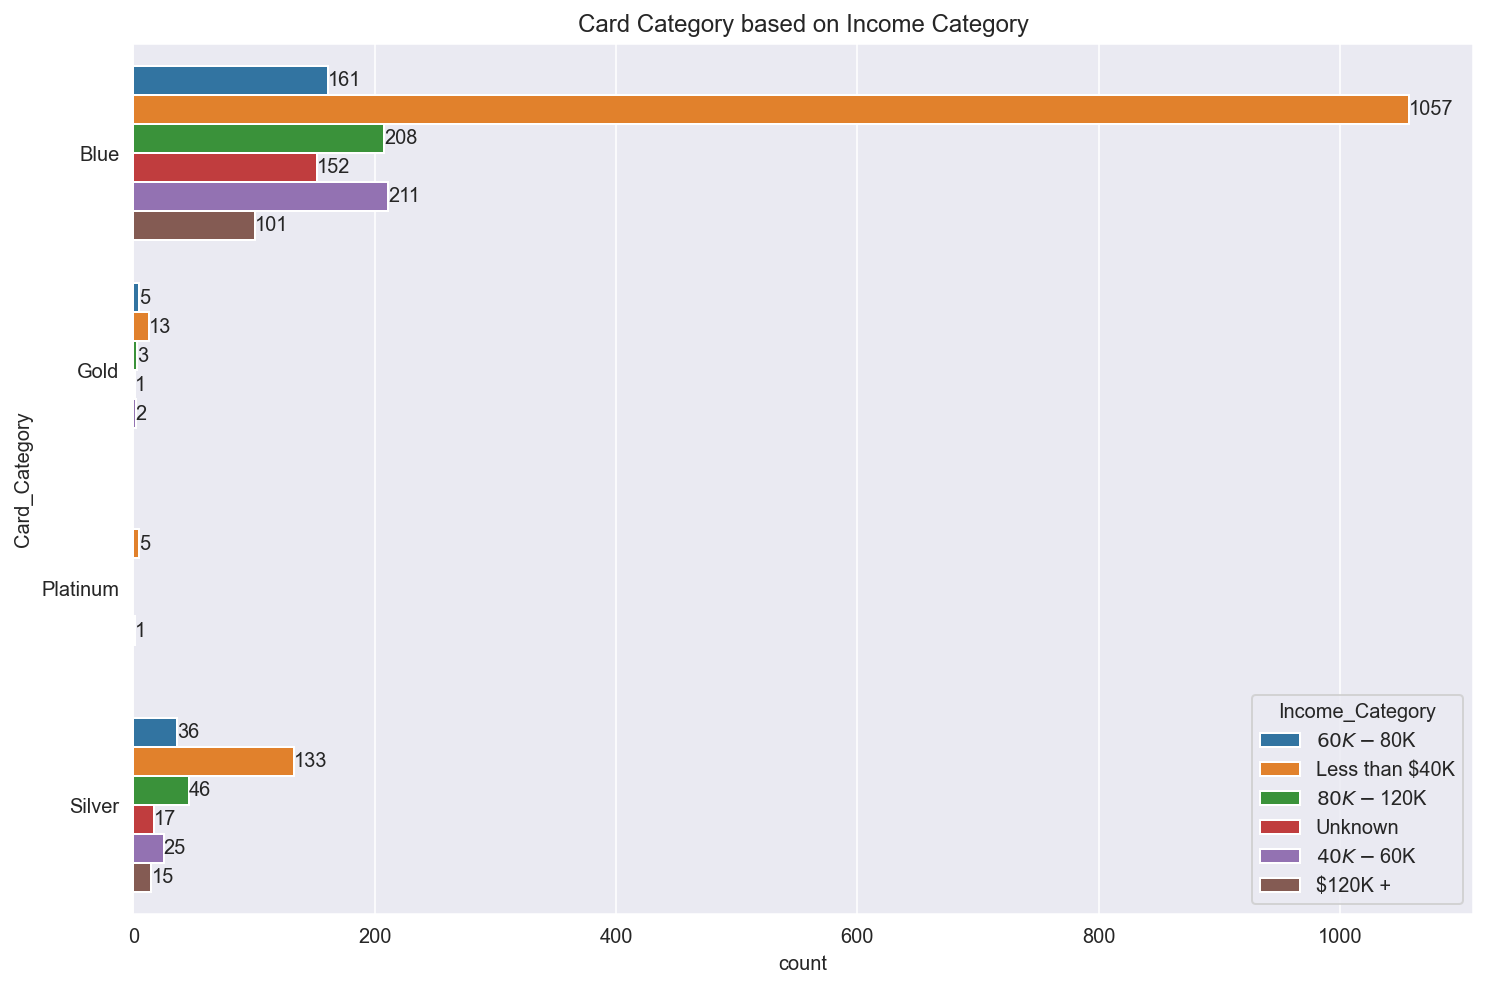

In [11]:
report(data, show = "Card_Category", based_on = "Attrition")
report(attrited_data, show = "Card_Category", based_on = "Income_Category", show_table = False)

**Observations**:
- Silver card has the highest attrition among all card types (38.7%)
    - Among all attrited customers using silver cards, around half of them have <40k income

Hypothesis: Low income people try the silver card because of good benefits, but then soon after a while realize that its too expensive, end up attriting.

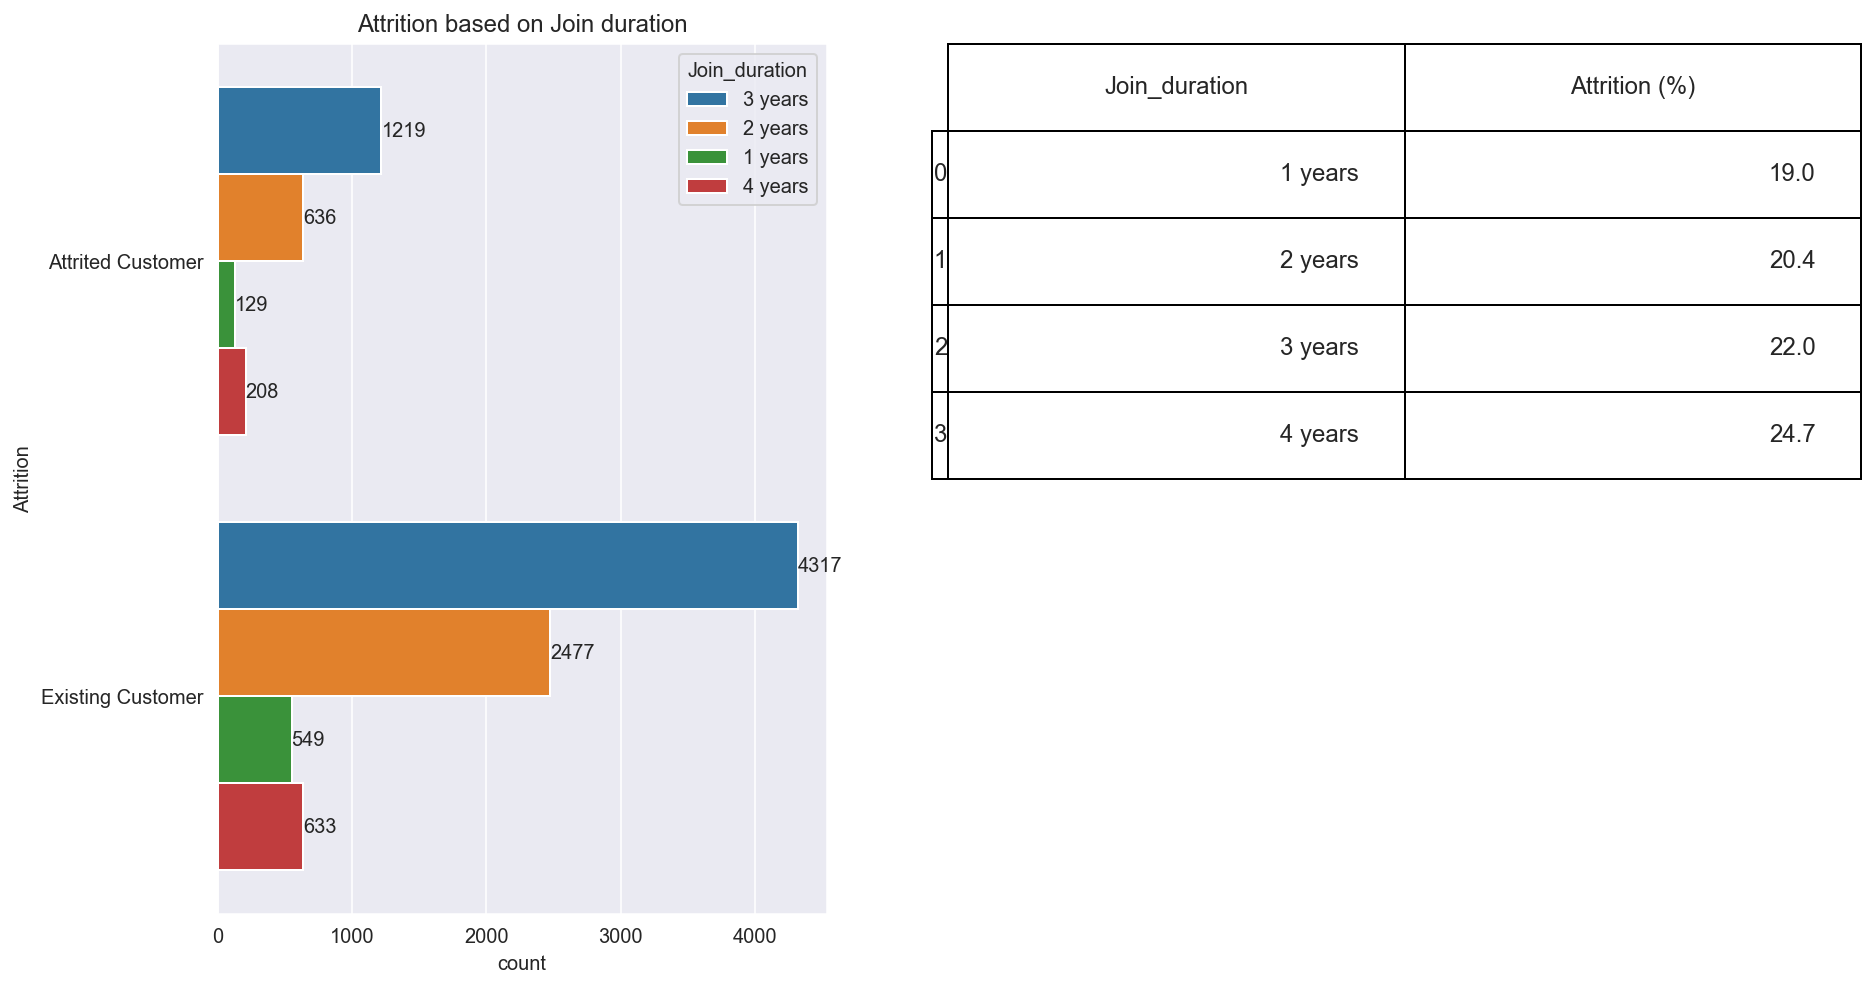

In [12]:
report(data, show = 'Attrition', based_on = "Join_duration")

In [13]:
from sklearn.cluster import KMeans

In [14]:
from sklearn.model_selection import train_test_split

dt = pd.get_dummies(data, drop_first = True)

X = dt.drop(['Attrition_Existing Customer'], axis = 1)
y = dt['Attrition_Existing Customer']

train_X, test_X, train_y, test_y = train_test_split(X, y)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


lr = LogisticRegression(tol = 1e-5, C = 1, max_iter = 500)
rf = RandomForestClassifier()
lr.fit(train_X, train_y)
rf.fit(train_X, train_y)
lr.score(test_X, test_y)
rf.score(test_X, test_y)

0.8591660110149488

In [15]:
{l:f for l,f in zip(rf.feature_names_in_, rf.feature_importances_) if f > 0.05}

{'Dependent_count': 0.08196500317895884,
 'Products_Owned': 0.08423932803402182,
 'Months_Inactive_12_mon': 0.06948832655303465,
 'Contacts_Count_12_mon': 0.09391684026299427,
 'Credit_Limit': 0.18175034037189586,
 'Age_20-29': 0.060748403472308386}